# Ashrae Energy Predection


## 1.Business/Real-world Problem

## 1.1.Problem Statement


#### Develop accurate predictions of metered building energy usage in the following areas: chilled water, electric, natural gas, hot water, and steam meters.The data comes from over 1,000 buildings over a three-year timeframe.

## 1.2 Source/Useful Links


#### The American Society of Heating, Refrigeration, and Air Conditioning Engineers ASHRAE is one of the largest energy efficiency research societies in the world.They were founded in 1894 and have over 54,000 members, serving 132 countries.Since 1993, they have hosted 3 large data competitions, aiming to predict building energy use. The most recent one was hosted in October 2019 on Kaggle.

#### https://www.youtube.com/watch?v=LLmVWZQR5Fg

#### https://www.kaggle.com/c/ashrae-energy-prediction

## 1.3 Real-world/Business objectives and constraints.

### Minimize Root Mean Squared Logarithmic Error.

# 2. Machine Learning Problem

## 2.1. Data

## 2.1.1. Data Overview

#### Very first observation is training and test data spans in 5 different csv files.

* train.csv, test.csv, weather_train.csv and weather_test.csv are time-series data, with hourly measurements.
 
#### building_metadata.csv contains the characteristics of a building such as:
* site id of the building
* primary use
* square feet
* year built

#### In the weather datasets, there are features related to wind, clouds, temperature and pressure.

* Weather_train dataset measured from 1 Jan, 2016 to 1 Jan, 2017.
 
* Weather_test dataset spans from 1 Jan, 2017 to 1, Jan 2019.


## 2.2 Mapping the real-world problem to an ML problem

### 2.2.1. Type of Machine Learning Problem



#### So using 1 year data we are going to predict following 2 years energy consumption of a building ===> We have regression problem

## 2.2.2. Performance Metric

#### Source: https://www.kaggle.com/c/ashrae-energy-prediction/overview/evaluation

## Metric(s):

#### Minimize Root Mean Squared Logarithmic Error.



# 2.3 Useful blogs, videos and reference papers

#### https://www.kaggle.com/yamsam/ashrae-leak-data-station

#### https://towardsdatascience.com/estimating-counterfactual-energy-usage-of-buildings-with-machine-learning-8ca91ec66c08

#### https://www.kaggle.com/datadugong/locate-better-cities-by-weather-temp-fill-nans

#### Roman, Kaggle Notebook, "EDA for ASHRAE." Retrieved January, 2020 from https://www.kaggle.com/nroman/eda-for-ashrae#meter

#### https://www.youtube.com/watch?v=LLmVWZQR5Fg

###########################################################################

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold
from tqdm import tqdm_notebook as tqdm
import datetime
from sklearn import metrics
from plotly.offline import init_notebook_mode,iplot,plot
import plotly.graph_objects as go
init_notebook_mode(connected=True)
import plotly.figure_factory as ff
import gc

# Load Data

In [0]:
building_df = pd.read_csv('../input/ashrae-energy-prediction/building_metadata.csv')
weather_df = pd.read_csv('../input/ashrae-energy-prediction/weather_train.csv')
weather_test_df = pd.read_csv('../input/ashrae-energy-prediction/weather_test.csv')
train_df = pd.read_csv('../input/ashrae-energy-prediction/train.csv')
test_df = pd.read_csv('../input/ashrae-energy-prediction/test.csv')

## memory reduction

In [0]:
# Original code from https://www.kaggle.com/gemartin/load-data-reduce-memory-usage by @gemartin

# Here's how reduce the memory usage of each dataframe. It can save from 60% to 75% of memory usage on each dataframe.

from pandas.api.types import is_datetime64_any_dtype as is_datetime
from pandas.api.types import is_categorical_dtype

def reduce_mem_usage(df, use_float16=False):
    """
    Iterate through all the columns of a dataframe and modify the data type to reduce memory usage.        
    """
    
    start_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage of dataframe is {:.2f} MB".format(start_mem))
    
    for col in df.columns:
        if is_datetime(df[col]) or is_categorical_dtype(df[col]):
            continue
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if use_float16 and c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype("category")

    end_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage after optimization is: {:.2f} MB".format(end_mem))
    print("Decreased by {:.1f}%".format(100 * (start_mem - end_mem) / start_mem))
    
    return df




In [0]:
# memory reduction
train_df = reduce_mem_usage(train_df,use_float16=True)
building_df = reduce_mem_usage(building_df,use_float16=True)
weather_df = reduce_mem_usage(weather_df,use_float16=True)
weather_df_test = reduce_mem_usage(weather_test_df,use_float16=True)
test_df = reduce_mem_usage(test_df,use_float16=True)

Memory usage of dataframe is 616.95 MB
Memory usage after optimization is: 173.90 MB
Decreased by 71.8%
Memory usage of dataframe is 0.07 MB
Memory usage after optimization is: 0.02 MB
Decreased by 73.8%
Memory usage of dataframe is 9.60 MB
Memory usage after optimization is: 2.65 MB
Decreased by 72.4%
Memory usage of dataframe is 19.04 MB
Memory usage after optimization is: 5.25 MB
Decreased by 72.4%
Memory usage of dataframe is 1272.51 MB
Memory usage after optimization is: 358.65 MB
Decreased by 71.8%


#############################################

# 3.Exploratory Data Analysis with pandas_profiling

#### Pandas_profiling is a great library to display information about

* Essentials
* Quantile statistics
* Descriptive statistics
* Most frequent values
* Histogram
* Correlations (even rejects a column if a collinear correlation is found)
* provides a Sample consisting of first and last rows.

https://towardsdatascience.com/exploratory-data-analysis-with-pandas-profiling-de3aae2ddff3

In [0]:
import pandas_profiling as pp
pd.set_option('display.max_columns', 100)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

### 3.1 building data

In [0]:
pp.ProfileReport(building_df)

######################





#### Building_id is the primary key for this dataset.

#### Observations coming from 1449 buildings.

#### building_id and site_id are collinear features.

#### More than 50% of the values are missing at columnsfloor_countand year_built which easily captured in the first raws of the data.

#### Except primary_use all of the columns are numeric.

#### primary_use column is categorical, most of the values being Education, Office and Public Assembly.

#### Looking at the square_feet histogram most of the buildings are smaller than 200.000 square feet. There are few extremely large buildings: square feet is more than 800.000 square feet.

#### We have buildings from every age: 2 year-old buildings to 100-year-old buildin****gs.

#### We have floor_count from min 1 to max 26 floors

#############################

### 3.2 weather data


In [0]:
pp.ProfileReport(weather_df)

#############

#### Since this is a time-series data, we have much more observations (139.773) than the building dataset.

#### Except timestamp, all of the features are numeric and in following units and ranges:

#### cloud_coverage, precip_depth_1_hr, sea_level_pressure and wind_direction have significantly high missing values.

##################




## Adding month and week features from time_stamp for monthly analysis of meter_reading 


In [0]:
def time_features(df):
    
    # Sort by timestamp
    df.sort_values("timestamp")
    df.reset_index(drop=True)
    
    # Add more features
    df["timestamp"] = pd.to_datetime(df["timestamp"],format="%Y-%m-%d %H:%M:%S")
    df["hour"] = df["timestamp"].dt.hour
    df["dayofweek"] = df["timestamp"].dt.weekday

    df['month'] = df['timestamp'].dt.month

   
    return df
weather_df  = time_features(weather_df)
train_df  = time_features(train_df)


## 3.3 train_df

### This is the biggest dataset in amongst the training datasets. Nearly has 20 million rows so its difficult to fit with pandas_profiling

In [0]:
train_df.shape

(20216100, 7)

In [0]:
print("Percentage of missing values in the train dataset")
train_df.isna().sum()

Percentage of missing values in the train dataset


building_id      0
meter            0
timestamp        0
meter_reading    0
hour             0
dayofweek        0
month            0
dtype: int64

## meter readings

Text(0.5, 1.0, 'Distribution of Meter Reading')

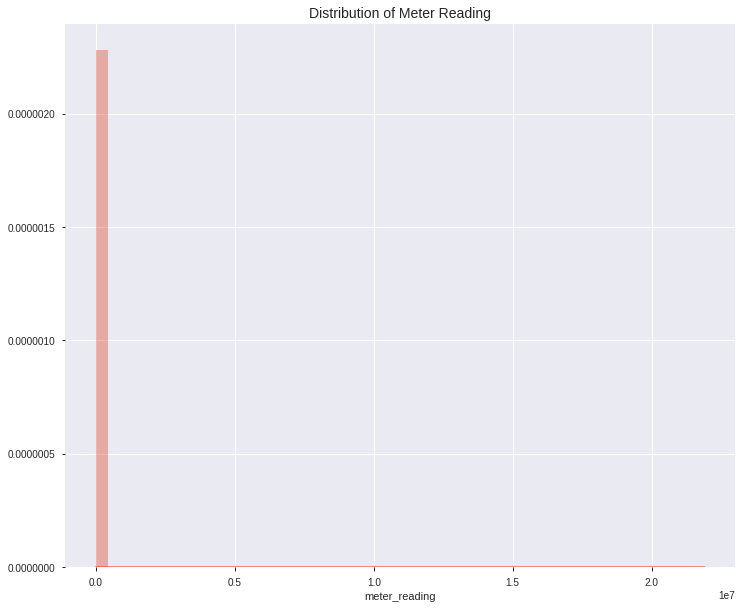

In [0]:
# set the plot size
from IPython.core.pylabtools import figsize
import seaborn as sns
figsize(12,10)

# set the histogram, mean and median
sns.distplot(train_df['meter_reading'],
             kde=True)

# set title, legends and labels
plt.title("Distribution of Meter Reading", size=14)


### Meter reading values are highly skewed.

### This picture shows that high percentage of them are gathered around zero. And unfortunately due this high skewness it is impossible to visualize raw meter reading values and draw a histogram.

###############

## log for meter_reading

Text(0.5, 1.0, 'Distribution of Meter Reading')

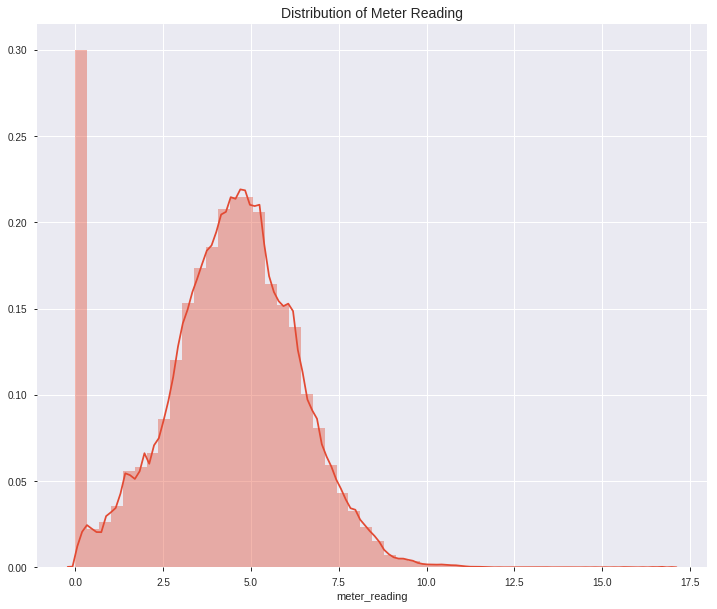

In [0]:
# set the histogram, mean and median
sns.distplot(np.log1p(train_df['meter_reading']),
             kde=True)

# set title, legends and labels
plt.title("Distribution of Meter Reading", size=14)


###  Median value is smaller than the mean value proving this skewness. This skewness is caused by the significanlty high number of 0 measurements in the meter_reading.

## without zero meter_readings

In [0]:
positive_train = train_df[train_df['meter_reading'] != 0]
positive_train['log_meter_reading'] = np.log(positive_train['meter_reading'])

Text(0.5, 1.0, 'Distribution of Logarithm(Meter Reading) w/o 0 Measurements')

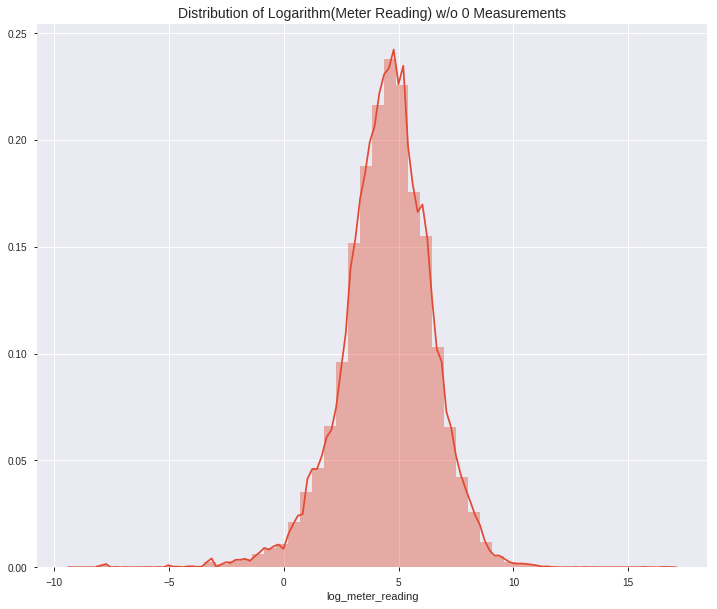

In [0]:
# set the plot size
figsize(12,10)

# set the histogram, mean and median
sns.distplot(positive_train['log_meter_reading'], 
             kde=True)


# set title, legends and labels
plt.title("Distribution of Logarithm(Meter Reading) w/o 0 Measurements", size=14)

##  meter reading among different meter categories

Text(0.5, 1.0, 'Density of Logartihm(Meter Reading + 1) Among Different Meters')

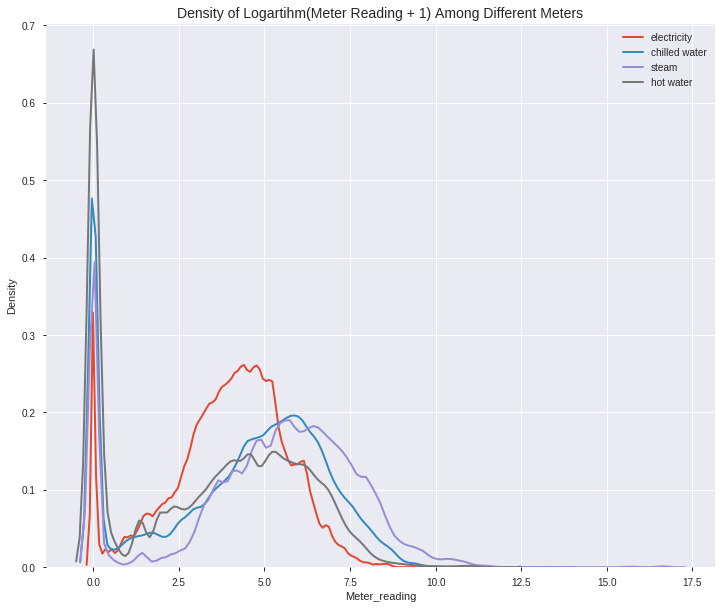

In [0]:
# distribution of the meter reading in meters without zeros
figsize(12,10)

#list of different meters
meters = sorted(train_df['meter'].unique().tolist())

# plot meter_reading distribution for each meter
for meter_type in meters:
    subset = train_df[train_df['meter'] == meter_type]
    sns.kdeplot(np.log1p(subset["meter_reading"]), 
                label=meter_type, linewidth=2)

# set title, legends and labels
plt.ylabel("Density")
plt.xlabel("Meter_reading")
plt.legend(['electricity', 'chilled water', 'steam', 'hot water'])
plt.title("Density of Logartihm(Meter Reading + 1) Among Different Meters", size=14)

#############

* Again for the visualization purposes, we are looking at the distribution of the np.log1p(meter_reading) values.

* One thing that is obvious is; significant number of observations 0 are coming from hot water, chilled water and steam consumption,meaning we have less missing values and 0 observations in the electricity usage.
 
* This picture shows that meter reading values shows different distribution in each meter category, especially electricity consumption is different than others. Thus, meter is a signifcant variable to determine the meter_reading values.

## monthly and hourly analysis of each meter_reading

### electricity meter

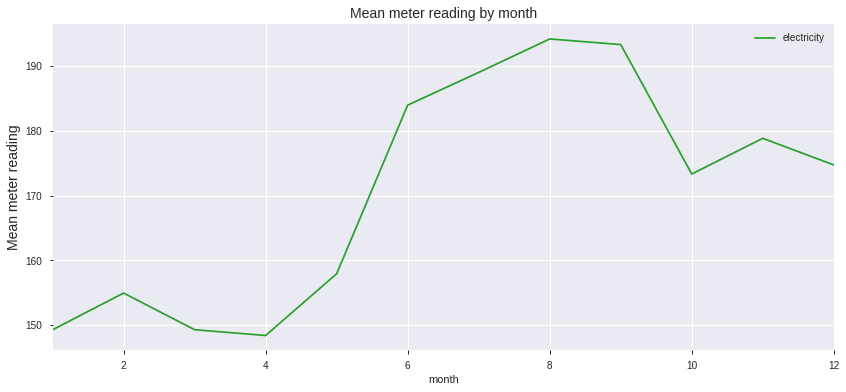

In [0]:
fig, axes = plt.subplots(1,1,figsize=(14, 6))

subset = train_df[train_df['meter'] == 0]
subset.groupby('month')['meter_reading'].mean().plot(color='#2ca02c');
axes.set_title('Mean meter reading by month', fontsize=14);
axes.set_ylabel('Mean meter reading', fontsize=14);

plt.legend(['electricity'])

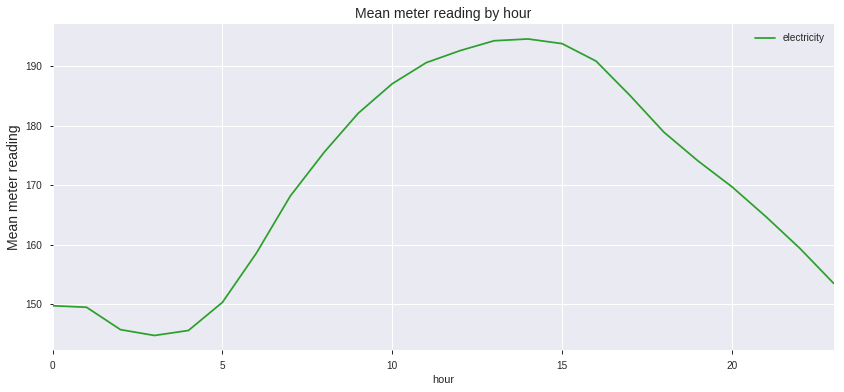

In [0]:
fig, axes = plt.subplots(1,1,figsize=(14, 6))

subset = train_df[train_df['meter'] == 0]
subset.groupby('hour')['meter_reading'].mean().plot(color='#2ca02c');
axes.set_title('Mean meter reading by hour', fontsize=14);
axes.set_ylabel('Mean meter reading', fontsize=14);

plt.legend(['electricity'])

#################

* Electricity observations spread between 0 and 220 kWh.

* Electricity meter readings are low till may

* For the first half of the year consumption does not exceed 160 kWh.

* for the second half consumption increases and ranges between 160 and 220 kWh. In general electricity consumption shows an increasing trend in 2016.

* daily peak electric comsuption comes at afternoon it averages nearly 190 kwh


### chilled water

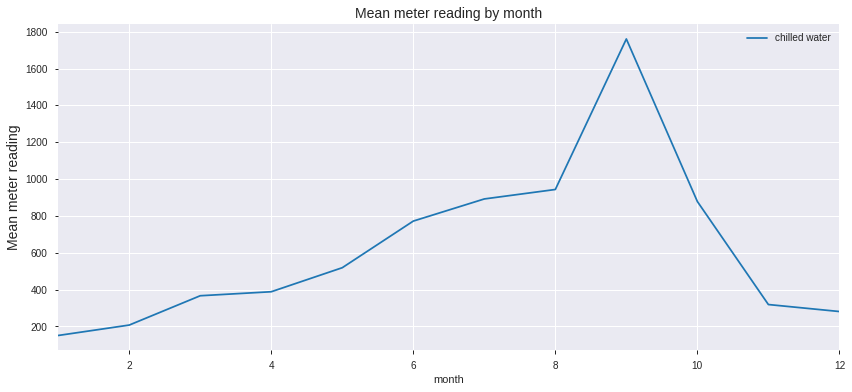

In [0]:
fig, axes = plt.subplots(1,1,figsize=(14, 6))

subset = train_df[train_df['meter'] == 1]
subset.groupby('month')['meter_reading'].mean().plot(color='#1f77b4');
axes.set_title('Mean meter reading by month', fontsize=14);
axes.set_ylabel('Mean meter reading', fontsize=14);
plt.legend(['chilled water'])

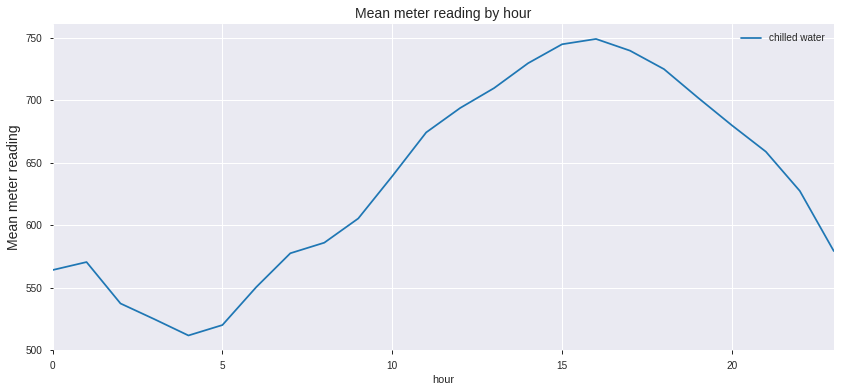

In [0]:
fig, axes = plt.subplots(1,1,figsize=(14, 6))

subset = train_df[train_df['meter'] == 1]
subset.groupby('hour')['meter_reading'].mean().plot(color='#1f77b4');
axes.set_title('Mean meter reading by hour', fontsize=14);
axes.set_ylabel('Mean meter reading', fontsize=14);
plt.legend(['chilled water'])


* Chilled water consumption ranges between 130 - 1800 kWh.

* It shows a steady increase up to 1000 kWh until September 2016. Between September and October, there are spikes in the consumption causing the range going up to 1800 kWh. 

* Starting from November it shows downward trend.

* chilled water meter is peak at afternoon as expected

## steam_meter

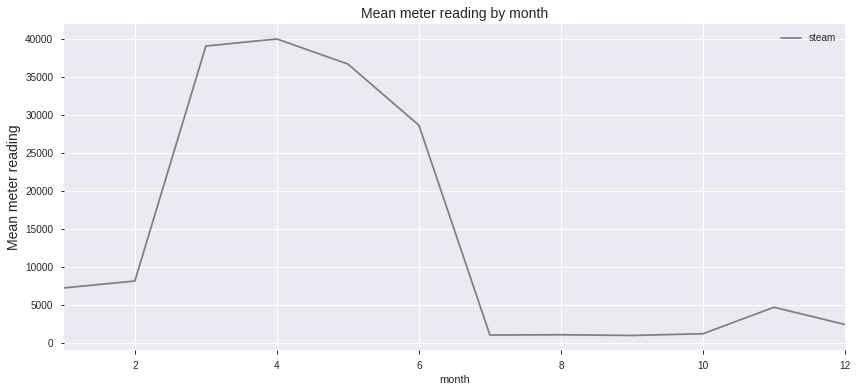

In [0]:
fig, axes = plt.subplots(1,1,figsize=(14, 6))

subset = train_df[train_df['meter'] == 2]
subset.groupby('month')['meter_reading'].mean().plot(color='#7f7f7f');
axes.set_title('Mean meter reading by month', fontsize=14);
axes.set_ylabel('Mean meter reading', fontsize=14);
plt.legend(['steam'])

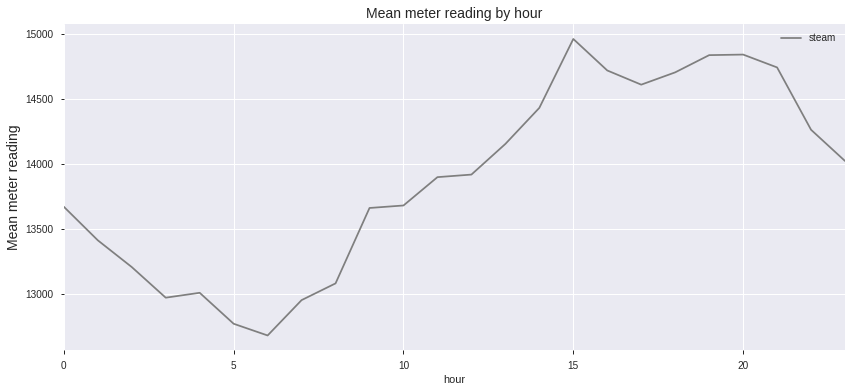

In [0]:
fig, axes = plt.subplots(1,1,figsize=(14, 6))

subset = train_df[train_df['meter'] == 2]
subset.groupby('hour')['meter_reading'].mean().plot(color='#7f7f7f');
axes.set_title('Mean meter reading by hour', fontsize=14);
axes.set_ylabel('Mean meter reading', fontsize=14);
plt.legend(['steam'])

* Steam consuption has the range: 0 - 20.000 kWh. 

* There is no obvious trend in the steam consumption and steam is utilized only in the first half of the year. 

* For the rest of the year, consumption decreases drastically  

* There is an interesting spike in the Nov 9, 2016.

* steam meter peak at afternoon 3'o clock  


## hot_water

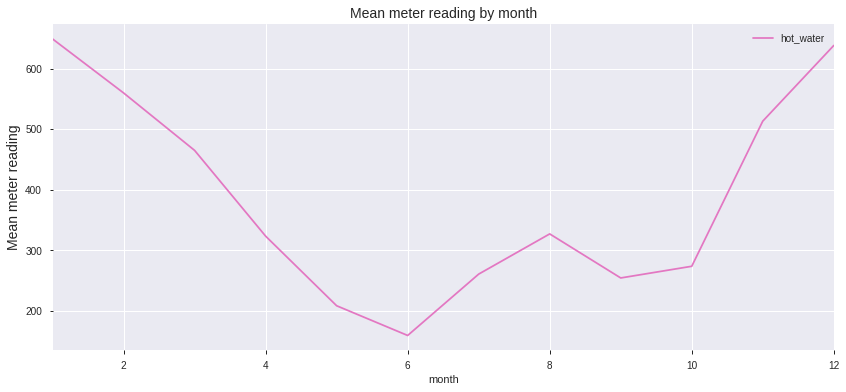

In [0]:
fig, axes = plt.subplots(1,1,figsize=(14, 6))

subset = train_df[train_df['meter'] == 3]
subset.groupby('month')['meter_reading'].mean().plot(color= '#e377c2');
axes.set_title('Mean meter reading by month', fontsize=14);
axes.set_ylabel('Mean meter reading', fontsize=14);
plt.legend(['hot_water'])

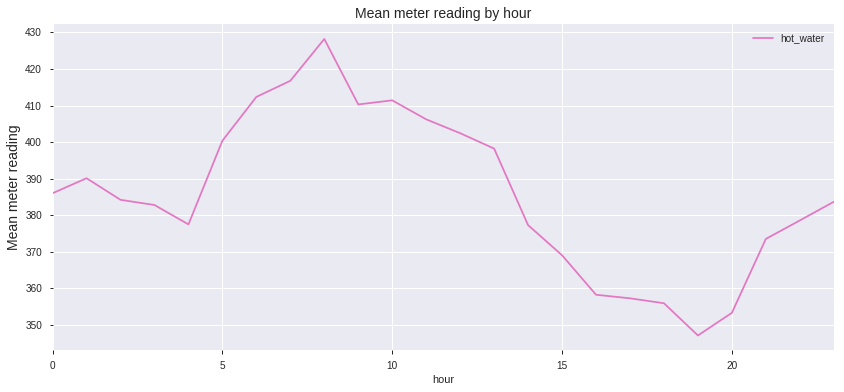

In [0]:
fig, axes = plt.subplots(1,1,figsize=(14, 6))

subset = train_df[train_df['meter'] == 3]
subset.groupby('hour')['meter_reading'].mean().plot(color= '#e377c2');
axes.set_title('Mean meter reading by hour', fontsize=14);
axes.set_ylabel('Mean meter reading', fontsize=14);
plt.legend(['hot_water'])

* Hot water meter ranges 0-500 Hot water consumtion is higher in the winter season and shows the lowest results between May and July. 

* The lesser consumption in summer season is a useful trend for our ML model to catch.
 
* hot water meter peaks at morning 

## outliers

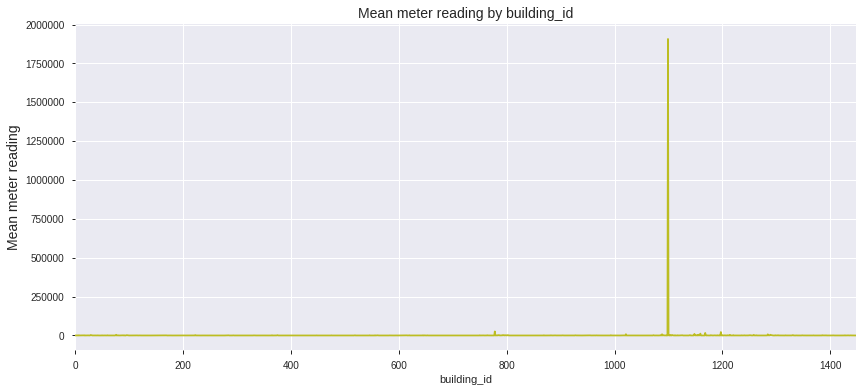

In [0]:
fig, axes = plt.subplots(1,1,figsize=(14, 6))
train_df.groupby('building_id')['meter_reading'].mean().plot(color='#bcbd22');
axes.set_title('Mean meter reading by building_id', fontsize=14);
axes.set_ylabel('Mean meter reading', fontsize=14);

######################

It is clear that building id 1099 showing high meter readings we can consider it as outlier



#######################

In [0]:
train_df[train_df['building_id'] == 1099]['meter_reading'].describe()

count      17566.000
mean     1907325.625
std      4834749.500
min          144.000
25%          520.391
50%          985.697
75%         7008.000
max     21904700.000
Name: meter_reading, dtype: float64

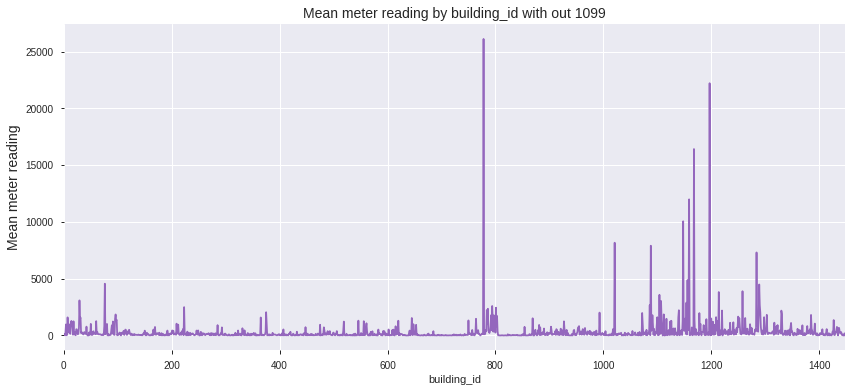

In [0]:
fig, axes = plt.subplots(1,1,figsize=(14, 6))
train_df[train_df['building_id'] != 1099].groupby('building_id')['meter_reading'].mean().plot(color='#9467bd');
axes.set_title('Mean meter reading by building_id with out 1099', fontsize=14);
axes.set_ylabel('Mean meter reading', fontsize=14);

## **Weather data**

In [0]:
import seaborn as sns
def plot_dist_col(column):
    '''plot dist curves for train and test weather data for the given column name'''
    fig, ax = plt.subplots(figsize=(10, 10))
    sns.distplot(weather_df[column].dropna(), color='green', ax=ax).set_title(column, fontsize=16)

    plt.xlabel(column, fontsize=15)
    plt.legend(['train'])
    plt.show()

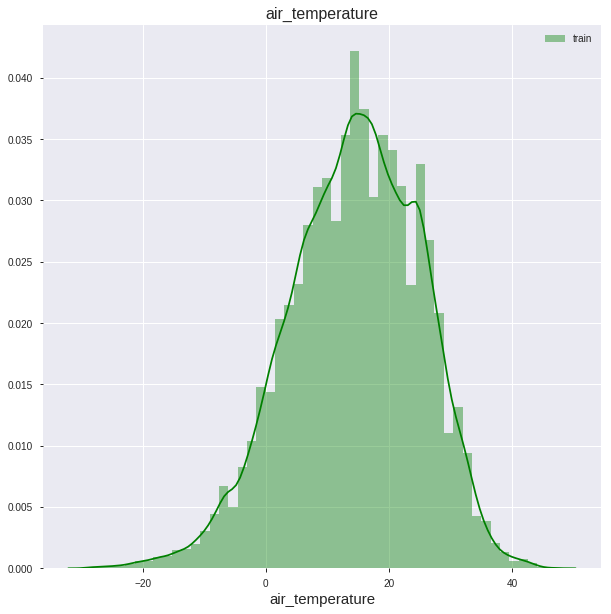

In [0]:
plot_dist_col('air_temperature')

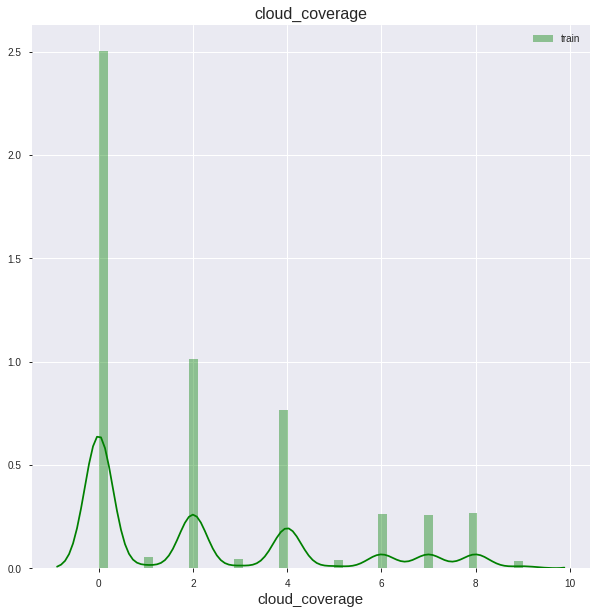

In [0]:
plot_dist_col('cloud_coverage')

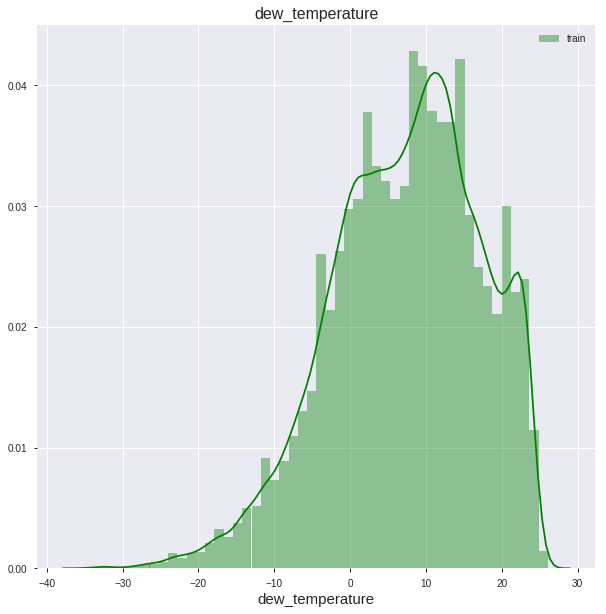

In [0]:
plot_dist_col('dew_temperature')

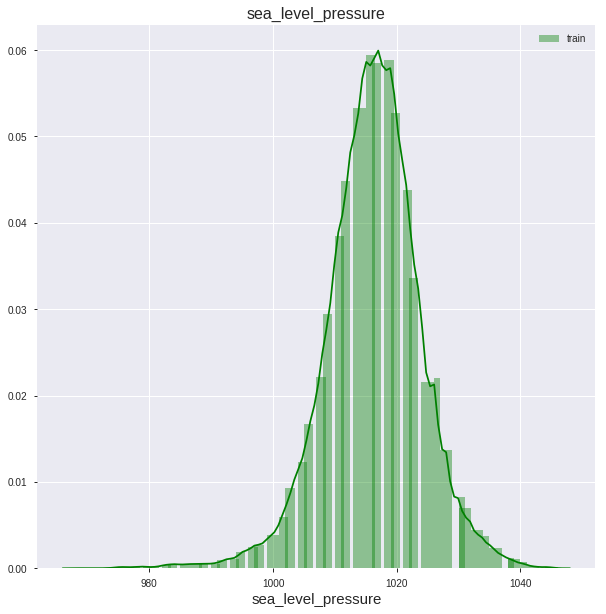

In [0]:
plot_dist_col('sea_level_pressure')

## Meter Reading among Site ID

In [0]:
# group train dataset per building and meter category
trainbld_df= (train_df.
                     groupby(["building_id", "meter"]).
                     meter_reading.mean().
                     reset_index())

In [0]:
trainbld_df = (trainbld_df.merge(building_df, 
                                  on='building_id', 
                                  how='left'))
trainbld_df['log_meter_reading'] = np.log1p(trainbld_df['meter_reading'])

In [0]:
import seaborn as sns
sns.set(style="whitegrid")



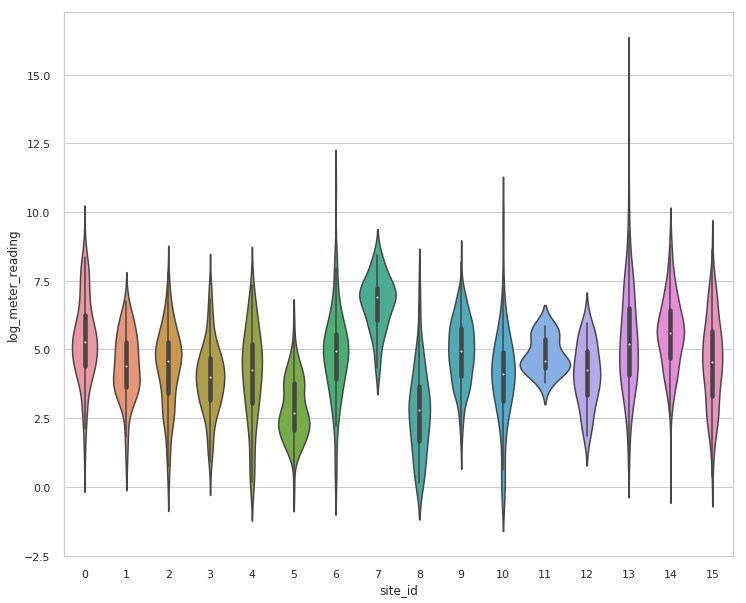

In [0]:
ax = sns.violinplot(x='site_id', y='log_meter_reading',gridsize=200, width=1.2,scale='area',data=trainbld_df)

#############################################

* Site ids 0, 1, 2, 3, 4, 5, 8, 9, 14 and 15 have similar meter reading distributions.

* Site ids 6 and 10 meter_reading values shares almost the same distribution and summary statistics.

* Site id 13 has the widest meter reading value range that goes beyond log_meter_reading_value 10.

* Site id 11 has the narrowest meter reading values range, centered around 5.

* Site id 13 shows the widest meter_reading distributions.


### meter reading vs floor count

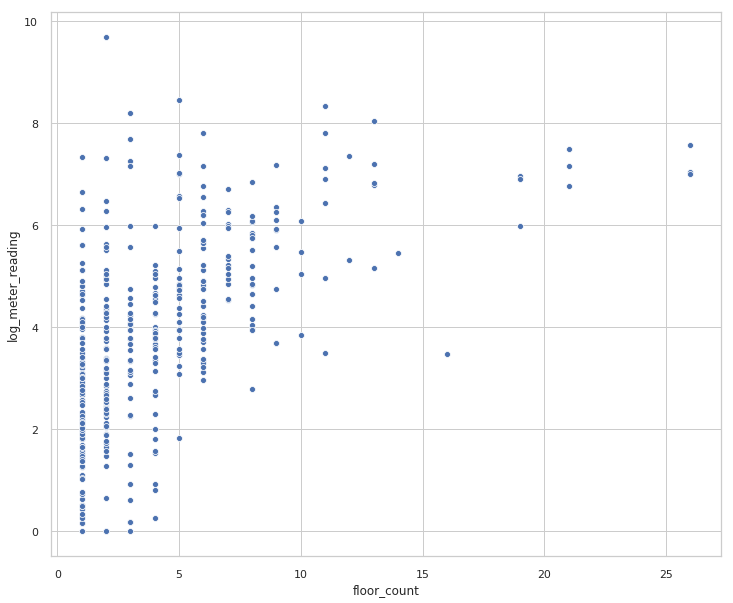

In [0]:
ax = sns.scatterplot(x="floor_count", y="log_meter_reading",
                     data=trainbld_df)

##########################################################

#### Due to the less data points we have in the floor_count, it is hard to extract some meaningful conclusions from the graph.

####################################################

# summery of EDA 


1) Imported necessary libraries mostly used seaboen and plotly libraries for plotting and analysis.

2) Then loading and Reducing size of data.

3) I Used the pandas profiling for data analysis of building and weather datasets 

4) As train dataset is large (nearly 20 million data points) i explored it manually

5) Added some time features like day_of_the_week and month to train dataset using timestamp column so we can digg it more

6) I stated analysing meter_reading it is so skewed so applied log to it then explored mean meter_reading of each meter per month and hour   

7) Found some outliers while analysing overall building mean reading

8) Then i merged train and building datasets to check mean meter_reading of each site id. plotted a violin plot there

    
    

### Observations and conclusions


* Meter reading values are higly and positively skewed. When we apply log1p function (calculates log(x+1)) to meter reading       values we are able to obtain meaningful visualizations and conclusions.


* After dropping the zero values and taking the logarithm of the meter reading values: Electricity shows a slightly different     distribution than other categories. 


* Chilled water and steam meter_reading shows similar distributions with close mean values. 


* Hot has more spikes than the other categories.


* There are significant number of 0 observations in the meter reading, which is due to erroneous or missing measurements. For     generating the predictions on meter reading this is a valuable information.


* Primary use, site id, year built (or age), square feet has a significant effect in determining meter reading values which also   intuitively makes sense. Floor_count has high missing values.


* Energy consumption has different data ranges among meter categories and shows different distributions.


* Chilled water and hot_water time-series consumption shows seasonality: Hot water consumption increases in winter and chilled     water consumption increases in summer. 


* Electricty  has an increasing trend towards the end of 2016. 


* There are no obvious patterns or seasonality effect in the steam consumption.


* Site ids 0, 1, 2, 3, 4, 5, 8, 9, 14 and 15 have similar meter reading distributions. Site ids 6 and 10 meter_reading values     shares almost the same distribution and summary statistics.Site id 13 has the widest meter reading value range that goes         beyond log_meter_reading_value 10.Site id 11 has the narrowest meter reading values range, centered around 5.Site id 13 shows   the widest meter_reading distributions.


* buiding 1099 is a absolute a outlier


* We have equal number of samples coming from 16 different sites.


* cloud_coverage, precip_depth_1_hr, sea_level_pressure and wind_direction have significantly high missing values.
